In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.models import load_model
import cv2 as cv

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
### Connecting to google drive ###
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [ ]:
os.chdir('/mydrive/Magnetics/Scripts')

In [ ]:
## Useful functions

from Utils.Utils_colab import *

In [ ]:
#os.chdir("../Database")
#!unzip V11_YOLO_par_3_3840.hdf5.zip
#os.chdir("../Scripts")

In [ ]:
hdf5_path = '../Database/V12_YOLO_par_3_9600.hdf5'

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_dataset_train_dev_test(hdf5_path)


In [ ]:
################ Confirming data retrieved shapes ###############

#Standardizing training data
#X_train_std = standardize_x_array(X_train)
#X_dev_std = standardize_x_array(X_dev)
#X_test_std = standardize_x_array(X_test)

##### to rgb
X_train = gray_to_rgb(X_train)
X_dev = gray_to_rgb(X_dev)
X_test = gray_to_rgb(X_test)

print("X_train shape : " + str(X_train.shape), "X_dev shape : " + str(X_train.shape), "X_test shape : " + str(X_train.shape)) 
print("Y_train shape : " + str(Y_train.shape), "Y_dev par shape : " + str(Y_dev.shape), "Y_test par shape : " + str(Y_test.shape)) 

X_train shape : (6720, 64, 64, 3) X_dev shape : (6720, 64, 64, 3) X_test shape : (6720, 64, 64, 3)
Y_train shape : (6720, 4) Y_dev par shape : (1920, 4) Y_test par shape : (960, 4)


In [ ]:
from keras import backend as K

def r2(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()))


In [ ]:
load_path = "/content/gdrive/My Drive/Magnetics/YOLOv4_magnetics/Parameters/Weights/Parameters/Densenet_par_8_TL.hdf5"

best_model = load_model(load_path, custom_objects={'r2': r2})

best_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
i=0
for layer in best_model.layers:
  
 print(f"{i}: {layer.name}")
 i+=1

0: input_1
1: zero_padding2d
2: conv1/conv
3: conv1/bn
4: conv1/relu
5: zero_padding2d_1
6: pool1
7: conv2_block1_0_bn
8: conv2_block1_0_relu
9: conv2_block1_1_conv
10: conv2_block1_1_bn
11: conv2_block1_1_relu
12: conv2_block1_2_conv
13: conv2_block1_concat
14: conv2_block2_0_bn
15: conv2_block2_0_relu
16: conv2_block2_1_conv
17: conv2_block2_1_bn
18: conv2_block2_1_relu
19: conv2_block2_2_conv
20: conv2_block2_concat
21: conv2_block3_0_bn
22: conv2_block3_0_relu
23: conv2_block3_1_conv
24: conv2_block3_1_bn
25: conv2_block3_1_relu
26: conv2_block3_2_conv
27: conv2_block3_concat
28: conv2_block4_0_bn
29: conv2_block4_0_relu
30: conv2_block4_1_conv
31: conv2_block4_1_bn
32: conv2_block4_1_relu
33: conv2_block4_2_conv
34: conv2_block4_concat
35: conv2_block5_0_bn
36: conv2_block5_0_relu
37: conv2_block5_1_conv
38: conv2_block5_1_bn
39: conv2_block5_1_relu
40: conv2_block5_2_conv
41: conv2_block5_concat
42: conv2_block6_0_bn
43: conv2_block6_0_relu
44: conv2_block6_1_conv
45: conv2_block

In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Magnetics/Scripts'

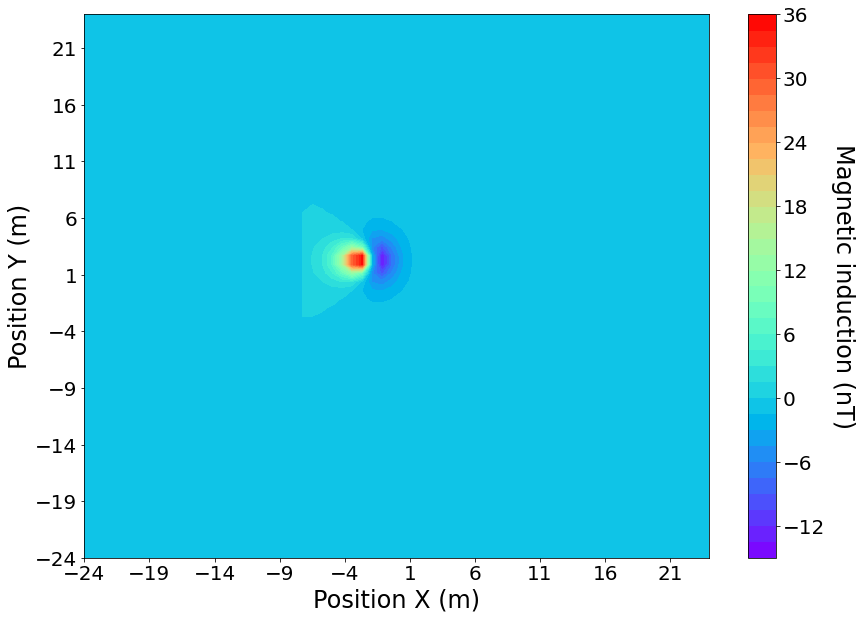

In [ ]:
last_conv_layer_name = "pool3_conv"
classifier_layer_names = [
    "Global_Average_Pooling_2D"
]

height_2 = 10
width_2 = 14

##############################

plt.figure(figsize=(width_2, height_2))

model = 6

Model_to_plot = X_test[model:model+1]

zmax = X_train.shape[1]
map_lenght = 24

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)
plt.contourf(X, Y, Model_to_plot[0,:,:,0], levels = 40, cmap='rainbow')
plt.xlabel('Position X (m)', fontsize=24)
plt.xticks(np.arange(-24, 26, step=5), fontsize=20)
plt.ylabel('Position Y (m)', fontsize=24)
plt.yticks(np.arange(-24, 26, step=5), fontsize=20)

clb = plt.colorbar()
ticklabs = clb.ax.get_yticklabels()
clb.ax.set_yticklabels(ticklabs, fontsize=20)
clb.set_label('Magnetic induction (nT)', labelpad=30, y=0.5, rotation=270, fontsize=24)

plt.savefig('gradcam_model.jpg', dpi=100)

In [ ]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

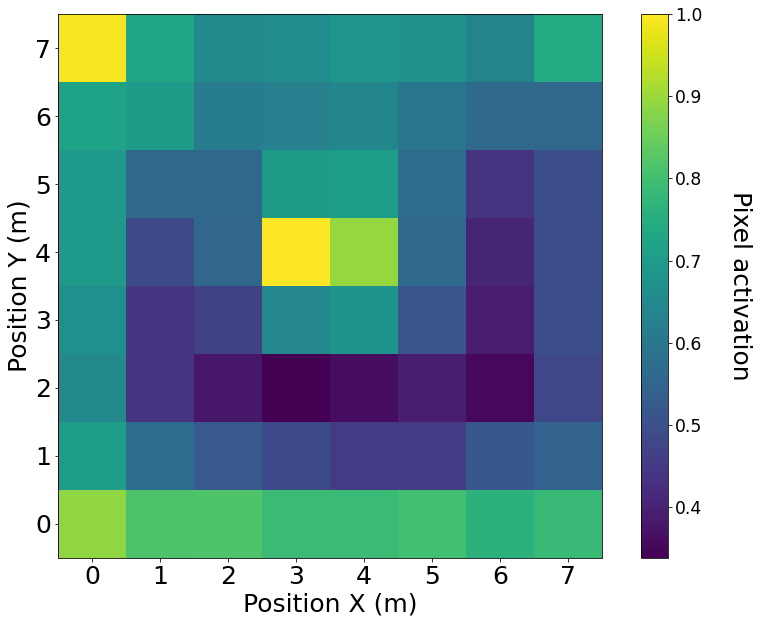

In [ ]:
preds = best_model.predict(Model_to_plot)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    Model_to_plot, best_model, last_conv_layer_name, classifier_layer_names
)

height_2 = 10
width_2 = 14

##############################

plt.figure(figsize=(width_2, height_2))

# Display heatmap
plt.imshow(heatmap, origin="lower")
plt.xlabel('Position X (m)', fontsize=25)
plt.xticks(np.arange(0, 8, step=1), fontsize=25)
plt.ylabel('Position Y (m)', fontsize=25)
plt.yticks(np.arange(0, 8, step=1), fontsize=25)

clb = plt.colorbar()
ticklabs = clb.ax.get_yticklabels()
#clb.ax.set_yticklabels(ticklabs, fontsize=20)
clb.set_label('Pixel activation', labelpad=50, y=0.5, rotation=270, fontsize=25)
clb.ax.tick_params(labelsize='xx-large')

#plt.show()

plt.savefig('pixel_activation_model.jpg', dpi=200)

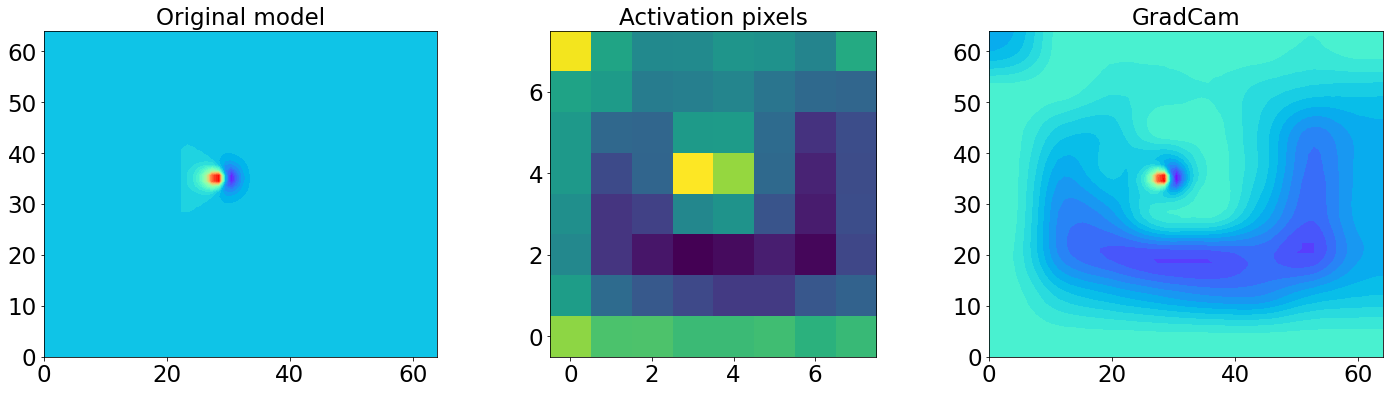

In [ ]:
# We rescale heatmap to a range 0-255
image = (Model_to_plot[0,:,:,:] - np.min(Model_to_plot[0,:,:,:])) / (np.max(Model_to_plot[0,:,:,:]) - np.min(Model_to_plot[0,:,:,:]))
image = np.uint8(image*255)  

heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.3 + image
#superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

#Display Grad CAM
zmax = X_train.shape[1]
map_lenght = 64

xmin = 0
xmax = map_lenght
ymin = 0
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)

fig, axs = plt.subplots(1,3, figsize=(24,6))
axs = axs.ravel()

font_size = 23
label_size = 23

axs[0].contourf(X, Y, Model_to_plot[0,:,:,0], levels = 40, cmap='rainbow')
axs[0].set_title("Original model", fontsize=font_size)
axs[0].tick_params(labelsize=label_size)
axs[1].imshow(heatmap, origin="lower")
axs[1].set_title("Activation pixels", fontsize=font_size)
axs[1].tick_params(labelsize=label_size)
axs[2].contourf(X, Y, superimposed_img[:,:,0], levels = 40, cmap='rainbow')
axs[2].set_title("GradCam", fontsize=font_size)
axs[2].tick_params(labelsize=label_size)
#plt.imshow(superimposed_img)

plt.savefig('synthetic_ex.pdf', dpi=200)

In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Magnetics/Scripts'

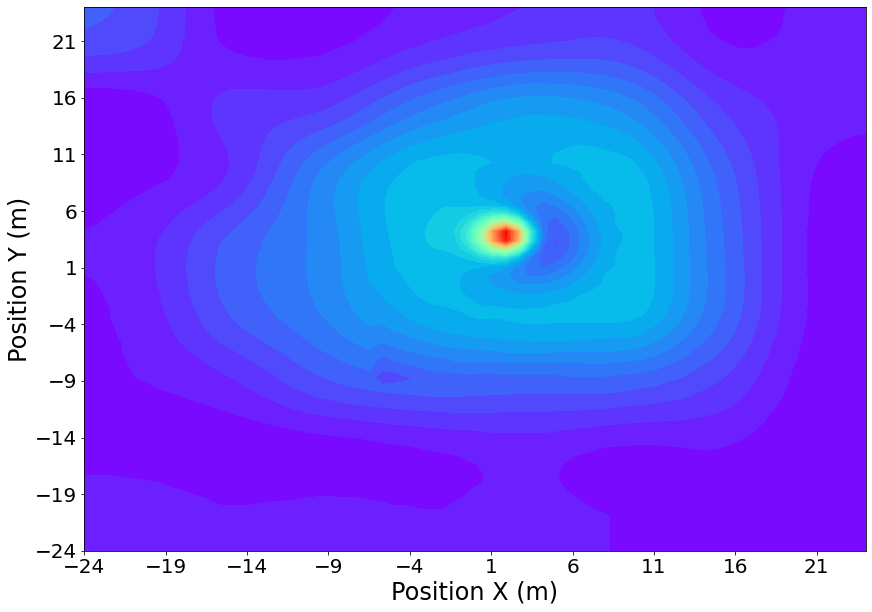

In [ ]:
height_2 = 10
width_2 = 14

##############################

plt.figure(figsize=(width_2, height_2))

zmax = X_train.shape[1]
map_lenght = 24

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)
plt.contourf(X, Y, superimposed_img[:,:,0], levels = 40, cmap='rainbow')
plt.xlabel('Position X (m)', fontsize=24)
plt.xticks(np.arange(-24, 26, step=5), fontsize=20)
plt.ylabel('Position Y (m)', fontsize=24)
plt.yticks(np.arange(-24, 26, step=5), fontsize=20)

#clb = plt.colorbar()
#ticklabs = clb.ax.get_yticklabels()
#clb.ax.set_yticklabels(ticklabs, fontsize=20)
#clb.set_label('Magnetic induction (nT)', labelpad=30, y=0.5, rotation=270, fontsize=24)

plt.savefig('gradcam_plus_model.jpg', dpi=100)